# Error Distribution Analysis

![/imgs/experiment.png](imgs/experiment.png)

This notebook dive deeper into the topic being explored in the previous [polinomial experiment](./polynomial_experiment.ipynb), results were extracted from a series of simulations and are shown in the graph above.

The graph displays the difference between the *expected generalization error* of two polynomial models, a more *complex* 10th order polynomial and a simpler 2nd order.

- **This notebook will explore the characteristics of the generalization error of both polynomial models**

## Method

1. The results show that exits under circunstances (of noise level and sample size) where the *expected generalization error* is indifferent from the model complexity, and both models perform similarly. This provides a ground for further investigation of how the error from the different models behavior.

2. Batches of fitting polynomials for both 10th and 2nd order are made from the same source of data that was used in the prior simulations.

3. From the computed generalizaiton error of each fitted model from the batches a histogram is made and a density function (pdf) is fitted on both distributions

4. finaly some aspects of the pdf and the cdf of the models are analysis with respecto to their complexity and the effects of the noise and sample size.

## *Table of Contents*

### 1. [Selecting Sample Sizes](#sample-sizes)
#### 1.1. Checking values on the neutral zone
#### 1.2. Selecting pairs $(N, \sigma)$

### 2. [Fitting Error Distribution](#fitting-error)
#### 2.1. Setting up scenarios
#### 2.2. Computing Distribution
##### 2.2.1. Low noise scenario
##### 2.2.2. High noise scenario
        

In [1]:
import resources.utils as utils
import resources.functk as ftk
import numpy as np
from scipy.stats import lognorm
from resources.utils import compute_batch
from resources.plot import heatmap, plot_distribution

---

## 1. Selecting sample sizes <a class="anchor" id="sample-sizes"></a>

**Goal**
* To set up the the rest of the notebook for the analysis to be undertaken

*The graph earlier hints there is a strip (with green-ish hues) where the models apparently equivalent with respective to their errors.*

The following cells are related to the process of choosing a couple o pairs $(N, \sigma)$ along that strip that best serves the main purpose o this notebook.

The sample sizes are chosen so that the effects of $\sigma$ can be observed, therefore the couple of chosen sample sizes should not have similar values for noise variance.

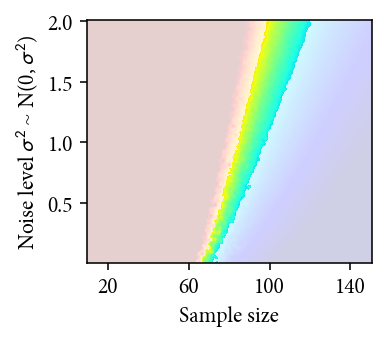

In [2]:
data = np.load('data.npy', allow_pickle=True).tolist()
sample_sizes = np.load('n_sizes.npy', allow_pickle=True)
noise_std = np.load('noise_std.npy', allow_pickle=True)
results = np.load('results.npy', allow_pickle=True)

green = np.array([1, .9, 1])
params = {'x_params':(10,151), 'y_params':(120,2)}
fig = heatmap(results, params=params, c_range=(-.2,.2), filter_color=green);
fig.savefig('imgs/strip.png')

### 1.1 Checking for the values in the green strip

In [3]:
close_to_zero = np.isclose(results, 0, atol=1e-3)
quantiles = np.quantile(results[close_to_zero], [.1, .5, .9])
print('Mean of close-to-zero values:\n\t%.2e\n'% np.mean(results[close_to_zero]))
print('Quantiles of close-to-zero values:\n10%%:\t% .2e \n50%%:\t% .2e \n90%%:\t% .2e'%(quantiles[0], quantiles[1], quantiles[2]))

Mean of close-to-zero values:
	-4.76e-05

Quantiles of close-to-zero values:
10%:	-8.66e-04 
50%:	-1.58e-04 
90%:	 7.93e-04


### 1.2 Selecting the pairs $(N, \sigma)$

In [4]:
noise = noise_std[close_to_zero]
size = sample_sizes[close_to_zero]
pairs = np.c_[size, noise]
print('Samples sizes ->', size)

Samples sizes -> [ 67.  75.  76.  79.  78.  81.  82.  80.  85.  86.  88.  89.  94.  95.
  96.  97.  98. 100. 102. 102. 104. 105. 105. 107. 108. 108.]


In [5]:
size75 = np.argwhere(size == 75)[0]
size105 = np.argwhere(size == 105)[0]
selection = pairs[np.hstack((size75, size105))]

print('Selected values')
print('---------------\n')
for n, noise in selection:
    print('Noise variance (sample size): %.1f (%d)'%(noise, int(n)))

Selected values
---------------

Noise variance (sample size): 0.4 (75)
Noise variance (sample size): 1.8 (105)


---

### 2. Fitting Error Distribution <a class="anchor" id="fitting-error"></a>

**Goal**

The following cells are intented to run simulation for the selected pairs $(N, \sigma)$ in order to possess their distribution.

A *density function* is then fit into the data to compute the CDF of each distributiuon


### 2.1 Setting up scenarios (low noise case and high noise case)

As it can be seen from the *green strip* on the simulation graph, the magnitude of noise, for which the *expected generalization error* of both models are approximately the same, correlates with the *sample size*. Thefore for the purpose of the analysis presented in this notebook, the data related to the *smaller* sample size will be referred to as `low noise scenario` and the data related with the *bigger* sample siz, `high noise scenario`.


| scenario   | sample size | oise std $\sigma$ |
| :--------- | ----------: | -----------------: |
| `low noise`  | 75 | 0.4 |
| `high noise` | 105 | 1.8 |

* Neutral strip

<img src="imgs/strip.png"/>


In [6]:
# setting basic parameters for batch simulation
seed = 42
rounds = 4000

params_s75 = {label:value for label,value in zip(['N', 'noise'], selection[0])}
params_s105 = {label:value for label,value in zip(['N', 'noise'], selection[1])}

# setting up batch maker
batches_curried = ftk.curry(utils.make_batch)
batches_on_data = batches_curried(data=data, rounds=rounds)
batches = batches_on_data([2, 10])

### 2.2 Computing Error Distribution

The **error** considered is the *sum of the squares* as in

$$ Error^{(i)} = \sum_D (Target - P^{(i)})^2 $$

Where:
* $D$ is the domain where both *Target* and $f^{(i)}$ are evaluated
* $P^{(i)}$ is the *ith* polynomial within the batch

On this fashion, a single batch will provide a variaty of *errors*, each one with respect to a fitting polynomial, all sharing a specific order of *complexity*.

The set of errors from a batch compose a particular distribution associated with the complexity of the polynomial used in the batch.

In [7]:
def compute_error(batch, data):
    """This function compute point-wise the error between each fitted
    polynomial and the target provided in *data*"""
    xs, target = zip(*data)
    values = compute_batch(batch, xs)
    return np.mean((np.r_[target] - values)**2, axis=1)
    
# setting up error computation
error_curried = ftk.curry(compute_error)
error_calc = error_curried(data=data)

### 2.2.1 Low Noise Scenario

The following cells compute the error from both batches, 2nd order polynomials and the 10th order polynomials, for the polynomials fitted off a *sample of size 75*

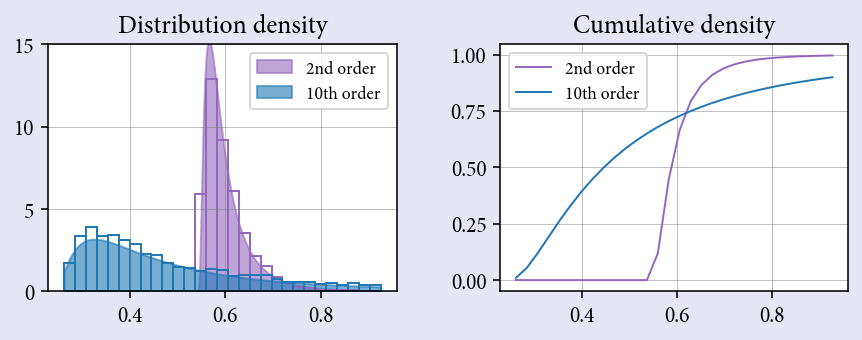

In [8]:
# computing the batches for 2nd and 10th order polynomials
simple_model_batch, complex_model_batch = batches(params=params_s75)

# computing the error for each batch
error_simple = error_calc(simple_model_batch)
error_complex = error_calc(complex_model_batch)

# fitting log-normal distribution
params_simple, params_complex = lognorm.fit(error_simple), lognorm.fit(error_complex)

# arranging data
case_simple = {'data':error_simple,
                'distribution':lognorm(*params_simple),
                'label':'2nd order',
                'color':'C4'}

case_complex = {'data':error_complex,
                 'distribution':lognorm(*params_complex),
                 'label':'10th order',
                 'color':'C0'}

# plotting data for sample size 75
fig = plot_distribution(case_simple, case_complex, bins=30)
fig.savefig('imgs/low_noise_case.png', bbox_inches='tight', facecolor='#e6e6e6')

### 2.2.2 High Noise Scenario

The following cells compute the error from both batches, 2nd order polynomials and the 10th order polynomials, for the polynomials fitted off a *sample of size 105*

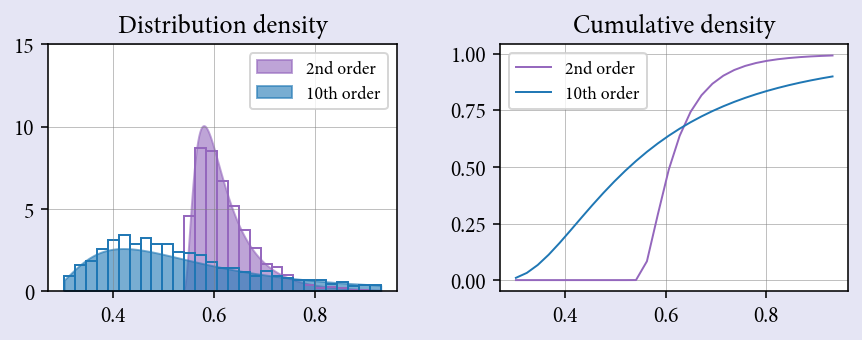

In [9]:
# computing the batches for 2nd and 10th order polynomials
simple_model, complex_model = batches(params=params_s105)

# computing the error for each batch
error_simple = error_calc(simple_model)
error_complex = error_calc(complex_model)

# fitting log-normal distribution
params_simple, params_complex = lognorm.fit(error_simple), lognorm.fit(error_complex)

# arranging data
case_simple = {'data':error_simple,
                'distribution':lognorm(*params_simple),
                'label':'2nd order',
                'color':'C4'}

case_complex = {'data':error_complex,
                 'distribution':lognorm(*params_complex),
                 'label':'10th order',
                 'color':'C0'}

# plotting data for sample size 75
fig = plot_distribution(case_simple, case_complex, bins=30)
fig.savefig('imgs/high_noise_case.png', bbox_inches='tight', facecolor='#e6e6e6')